# Auditory category tutorial:

## Getting started:
You can run this code on your local machine if you have ipython notebooks (install anaconda if you're new to python).

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Loading Data:

Assume data is in a directory called data

In [25]:
# Load data in a Pandas dataframe
fn0 = "../data/CAM24_BASELINE.csv"
df_baseline = pd.read_csv(fn0, header=0)

fn1 = "../data/CAM24_12HR.csv"
df_12hr = pd.read_csv(fn1, header=0)

fn2 = "../data/CAM24_48HR.csv"
df_48hr = pd.read_csv(fn2, header=0)

header_baseline = df_baseline.columns.values
header_12hr = df_12hr.columns.values
header_48hr = df_48hr.columns.values



In [26]:
# Filter out all cells that have empty entries. Only want the good stuff!
def GetGoodIndices( df ):
    N = len(df)
    bad_idx = []
    header = df.columns.values
    for h in header:
        A = np.where(np.isnan(df[h]))
        for a in A[0]:
            if a in bad_idx:
                continue
            else:
                bad_idx.append(a)

    good_idx = []
    for i in range(N):
        if i in bad_idx:
            continue
        else:
            good_idx.append(i)

In [27]:
baseline = df_baseline.T.values[:,GetGoodIndices(df_baseline)]
cam12hr = df_12hr.T.values[:, GetGoodIndices(df_12hr)]
cam48hr = df_48hr.T.values[:, GetGoodIndices(df_48hr)]


### MultiDim Class:
This is a Python class that will allow us to work with multidimensional spaces. This will grow over time.

In [28]:
class MultiDim:

    def Mean(self, data):
        """
        multidimensional arithmetic mean. 
        
        data: mxn matrix, where n is dimensionality of space and m is 
              number of samples
        """
        return np.nanmean(data, 0)
        

    def Var(self, data):
        return np.nanvar(data, 0)
    
    
    def Distance(self, a, b, distance='euclidean'):
        """
        Get distance between two points in n dimesnional space
        
        a: n dim vector
        b: n dim vector
        distance: [euclidean], distance metric to use. only euclidean 
                  distance supported for now.
        """
        return np.linalg.norm( a - b )
    
    
    def Radius(self, data, distance='euclidean'):
        """
        Get radius of ball, defined by distance of furthest point from mean
        
        data: mxn matrix, where n is dimensionality of space and m is 
              number of samples
              
        distance: [euclidean], is distance metric to use. Only euclidean 
                  distance supported for now.
        """
        mean = self.Mean(data)
        m = np.shape(data)[0]
        radius = 0
        for i in range(m):
            tmp = self.Distance( mean, data[i,:], distance=distance )
            if tmp > radius:
                radius = tmp
        return radius
    
    
    def ConstructDistanceMatrix( self, points, distance='euclidean' ):
        """
        Construct a distance matrix between given points
        
        points: mxn matrix, where n is dimensionality of space and m is
                number of points
        
        distance: [euclidean], is distance metric to use. Only euclidean
                  distance supported for now
                  
        A: mxm symmetric matrix where element [i,j] is distance between 
           points i and j. 
        """
        m = np.shape(points)[0]
        A = np.zeros( (m,m) )
        for i in range(m):
            for j in range(i, m):
                A[i,j] = self.Distance( points[i,:], points[j,:], distance=distance )
                A[j,i] = A[i,j]
        return A
    
    def MDS(self, A ):
        """
        Classical MDS
        
        A: nxn matrix. Should be symmetric. Represents distances
        
        Y: (n, p) configuration matrix where each column is a dimension.
           only returns up to p dimensions (positive eigenvalues)
        
        eval: eigenvalues
        """
        n = len(A)
        H = np.eye(n) - np.ones((n,n))/n
        B = -H.dot(np.square(A)).dot(H)/2

        evals, evecs = np.linalg.eigh(B)

        idx = np.argsort(evals)[::-1]
        evals = evals[idx]
        evecs = evecs[:,idx]

        w, = np.where(evals > 0)
        L = np.diag(np.sqrt(evals[w]))
        V = evecs[:,w]
        Y = V.dot(L)

        return Y, evals

### Transforming the space:

Here we will assume that each of the conditions represent a different cateogry. We assume euclidean distance everywhere (no reason to believe this, implies linearity and therefore simplest assumption). 

We will find a lower dimensional subspace that maximizes the pairwise distance between the different categories. Everything is linear, so classical MDS will be used.

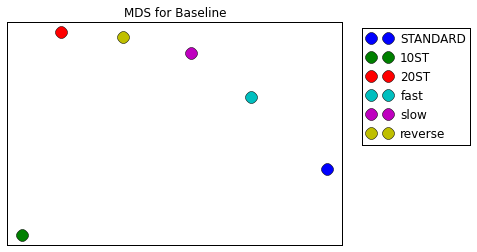

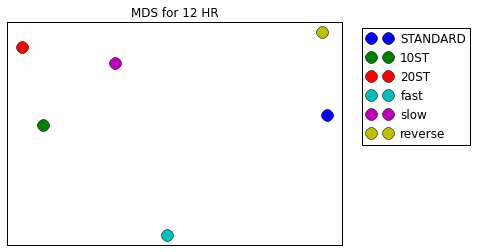

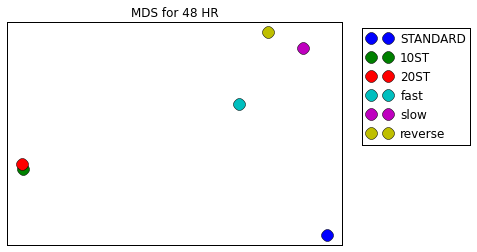

In [54]:
MD = MultiDim()

b_means = []
for d in baseline:
    b_means.append(MD.Mean(d))
b_means = np.array(b_means)

cam12hr_means = []
for d in cam12hr:
    cam12hr_means.append(MD.Mean(d))
cam12hr_means = np.array(cam12hr_means)

cam48hr_means = []
for d in cam48hr:
    cam48hr_means.append(MD.Mean(d))
cam48hr_means = np.array(cam48hr_means)

b_D = MD.ConstructDistanceMatrix( b_means )
cam12hr_D = MD.ConstructDistanceMatrix( cam12hr_means )
cam48hr_D = MD.ConstructDistanceMatrix( cam48hr_means )

b_mds_Y, b_mds_evals = MD.MDS( b_D )
cam12hr_mds_Y, cam12hr_mds_evals = MD.MDS( cam12hr_D )
cam48hr_mds_Y, cam48hr_mds_evals = MD.MDS( cam48hr_D )

Y_b = np.dot(b_mds_Y.T[:2,:], b_D)
Y_cam12hr = np.dot(cam12hr_mds_Y.T[:2,:], cam12hr_D)
Y_cam48hr = np.dot(cam48hr_mds_Y.T[:2,:], cam48hr_D)


# plot
fig, ax0 = plt.subplots()
ax0.margins(0.05)
for i in range(np.shape(Y_b)[1]):
    ax0.plot(Y_b[0,i], Y_b[1,i], marker='o', linestyle='', ms=12, label=header_baseline[i])
ax0.legend(bbox_to_anchor=(1.4, 1))
plt.title("MDS for Baseline")
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

# plot
fig, ax1 = plt.subplots()
ax1.margins(0.05)
for i in range(np.shape(Y_b)[1]):
    ax1.plot(Y_cam12hr[0,i], Y_cam12hr[1,i], marker='o', linestyle='', ms=12, label=header_baseline[i])
ax1.legend(bbox_to_anchor=(1.4, 1))
plt.title("MDS for 12 HR")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

# plot
fig, ax2 = plt.subplots()
ax2.margins(0.05)
for i in range(np.shape(Y_b)[1]):
    ax2.plot(Y_cam48hr[0,i], Y_cam48hr[1,i], marker='o', linestyle='', ms=12, label=header_baseline[i])
ax2.legend(bbox_to_anchor=(1.4, 1))
plt.title("MDS for 48 HR")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

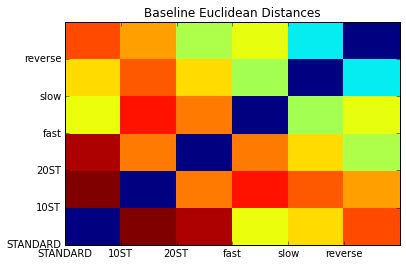

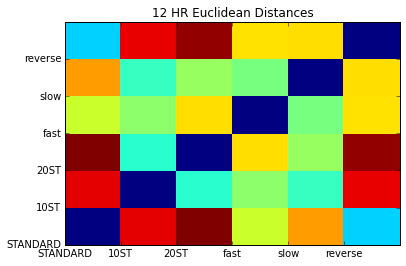

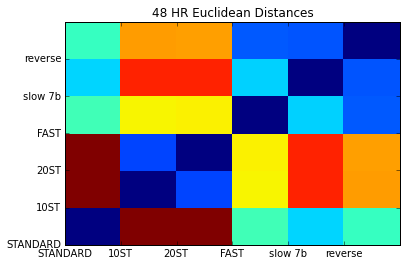

In [53]:
fig, ax0 = plt.subplots();
plt.pcolor(b_D);
ax0.set_xticklabels(header_baseline, minor=False);
ax0.set_yticklabels(header_baseline, minor=False);
plt.title("Baseline Euclidean Distances");

fig, ax1 = plt.subplots();
plt.pcolor(cam12hr_D);
ax1.set_xticklabels(header_12hr, minor=False);
ax1.set_yticklabels(header_12hr, minor=False);
plt.title("12 HR Euclidean Distances");

fig, ax2 = plt.subplots();
plt.pcolor(cam48hr_D);
ax2.set_xticklabels(header_48hr, minor=False);
ax2.set_yticklabels(header_48hr, minor=False);
plt.title("48 HR Euclidean Distances");